# Application of supervised learning

The goal of the following notebook is to demonstrate multiple supervised learning technique on the dataset [**Media Campaign Cost Prediction**](https://www.kaggle.com/datasets/gauravduttakiit/media-campaign-cost-prediction).

## Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from pathlib import Path

from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
)

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
)
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.features import Rank2D
from yellowbrick.model_selection import feature_importances
from yellowbrick.regressor import prediction_error

import matplotlib.pyplot as plt

# Solve font issue caused by yellowbricks
plt.rcParams["font.family"] = "DejaVu Sans"

from lightgbm import LGBMRegressor, plot_importance

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error, make_scorer

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.decomposition import PCA
import optuna

/home/h/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Constants

Constants are define for reproducibility purposes.

In [2]:
SEED = 42
DATA_PATH = Path("../data/supervised")

## The dataset

The dataset is composed of 15 features, including categorical and continuous features. The license of the dataset is CC0: Public Domain. The target is to predict the cost of a media campaign for a product across different stores. The features provide information about the stores themselves, the clients of the stores, and their infrastructures. The dataset originates from authentic data belonging to Food Mart (CFM), a renowned chain of convenience stores operating in the United States.

## Loading the data

To begin, we load the dataset and take a preliminary glance at its features.

In [3]:
df_train = pd.read_csv(DATA_PATH / "train_dataset.csv")
df_test = pd.read_csv(DATA_PATH / "test_dataset.csv")

Firstly we take a look a the train dataset information and description.

In [4]:
df_train.describe(include="all")

store_sales(in millions)  unit_sales(in millions)  total_children  \
count              51363.000000             51363.000000    51363.000000   
mean                   6.531792                 3.091194        2.538111   
std                    3.464902                 0.827293        1.489316   
min                    0.510000                 1.000000        0.000000   
25%                    3.800000                 3.000000        1.000000   
50%                    5.940000                 3.000000        3.000000   
75%                    8.640000                 4.000000        4.000000   
max                   22.920000                 6.000000        5.000000   

       num_children_at_home  avg_cars_at home(approx).1  gross_weight  \
count          51363.000000                51363.000000  51363.000000   
mean               0.832019                    2.199424     13.805512   
std                1.303775                    1.109080      4.622431   
min                0.000000                    0.000000      6.000000   
25%                0.000000                    1.000000      9.700000   
50%                0.000000                    2.000000     13.600000   
75%                1.000000                    3.000000     17.700000   
max                5.000000                    4.000000     21.900000   

       recyclable_package       low_fat  units_per_case    store_sqft  \
count        51363.000000  51363.000000    51363.000000  51363.000000   
mean             0.558437      0.351148       18.856550  27979.153593   
std              0.496578      0.477334       10.263746   5701.145280   
min              0.000000      0.000000        1.000000  20319.000000   
25%              0.000000      0.000000       10.000000  23593.000000   
50%              1.000000      0.000000       19.000000  27694.000000   
75%              1.000000      1.000000       28.000000  30797.000000   
max              1.000000      1.000000       36.000000  39696.000000   

         coffee_bar   video_store     salad_bar  prepared_food       florist  \
count  51363.000000  51363.000000  51363.000000   51363.000000  51363.000000   
mean       0.612367      0.353776      0.588011       0.588011      0.561825   
std        0.487215      0.478145      0.492198       0.492198      0.496168   
min        0.000000      0.000000      0.000000       0.000000      0.000000   
25%        0.000000      0.000000      0.000000       0.000000      0.000000   
50%        1.000000      0.000000      1.000000       1.000000      1.000000   
75%        1.000000      1.000000      1.000000       1.000000      1.000000   
max        1.000000      1.000000      1.000000       1.000000      1.000000   

               cost  
count  51363.000000  
mean      99.327064  
std       30.023458  
min       50.790000  
25%       69.650000  
50%       98.520000  
75%      126.620000  
max      149.750000

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51363 entries, 0 to 51362
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   store_sales(in millions)    51363 non-null  float64
 1   unit_sales(in millions)     51363 non-null  float64
 2   total_children              51363 non-null  float64
 3   num_children_at_home        51363 non-null  float64
 4   avg_cars_at home(approx).1  51363 non-null  float64
 5   gross_weight                51363 non-null  float64
 6   recyclable_package          51363 non-null  float64
 7   low_fat                     51363 non-null  float64
 8   units_per_case              51363 non-null  float64
 9   store_sqft                  51363 non-null  float64
 10  coffee_bar                  51363 non-null  float64
 11  video_store                 51363 non-null  float64
 12  salad_bar                   51363 non-null  float64
 13  prepared_food               513

**Observations:**  
- We have 7 boolean feature already encoded with 0 and 1
- 4 continious features 

Now we can identify and explain the features with the following research and description on the kaggle page.

The dataset is composed of 15 features:
- *store_sales(in millions)*: continious feature of the store sales in millions 
- *unit_sales(in millions)*: continious feature of the stores describing the total unit  
- *total_children*: categorical feature describing the number of children between 0 and 5            
- *num_children_at_home*: categorical feature total children at home as per customer
- *avg_cars_at home(approx).1*: categorical feature average car at home as per customer
- *gross_weight*: continious feature describing the grocery weight              
- *recyclable_package*: categorical feature 0 or 1 recyclable package
- *low_fat*: categorical feature 0 or 1 low fat product
- *units_per_case*: continious feature units case units available in each store shelves.
- *store_sqft*: continious feature units store square foot      
- *coffee_bar*: categorical feature 0 or 1 has a coffee bar
- *video_store*: categorical feature 0 or 1 has a video store              
- *salad_bar*: categorical feature 0 or 1 has a salar_bar
- *prepared_food*: categorical feature 0 or 1 does prepare food
- *florist*: categorical feature 0 or 1 has a florist
- *cost*: continious target variable the cost of the media campaign

In [6]:
CONTINIOUS_FEATURES = [
    "store_sales(in millions)",
    "unit_sales(in millions)",
    "gross_weight",
    "store_sqft",
]

CATEGORICAL_FEATURES = [
    "avg_cars_at home(approx).1",
    "low_fat",
    "prepared_food",
    "coffee_bar",
    "recyclable_package",
    "florist",
    "num_children_at_home",
    "video_store",
    "salad_bar",
    "units_per_case",
    "total_children",
]

TARGET = "cost"

In [7]:
X, y = df_train.drop(columns=[TARGET]), df_train[TARGET]

#### Dimensionality

In [8]:
print(f"The datashape is composed of {X.shape[0]} samples and {X.shape[1]} features.")

The datashape is composed of 51363 samples and 15 features.


## Distributions

Now, let's leverage the power of seaborn's pairplot function to examine the distribution of our continuous features. This will allow us to gain valuable insights into the patterns and relationships within our data.

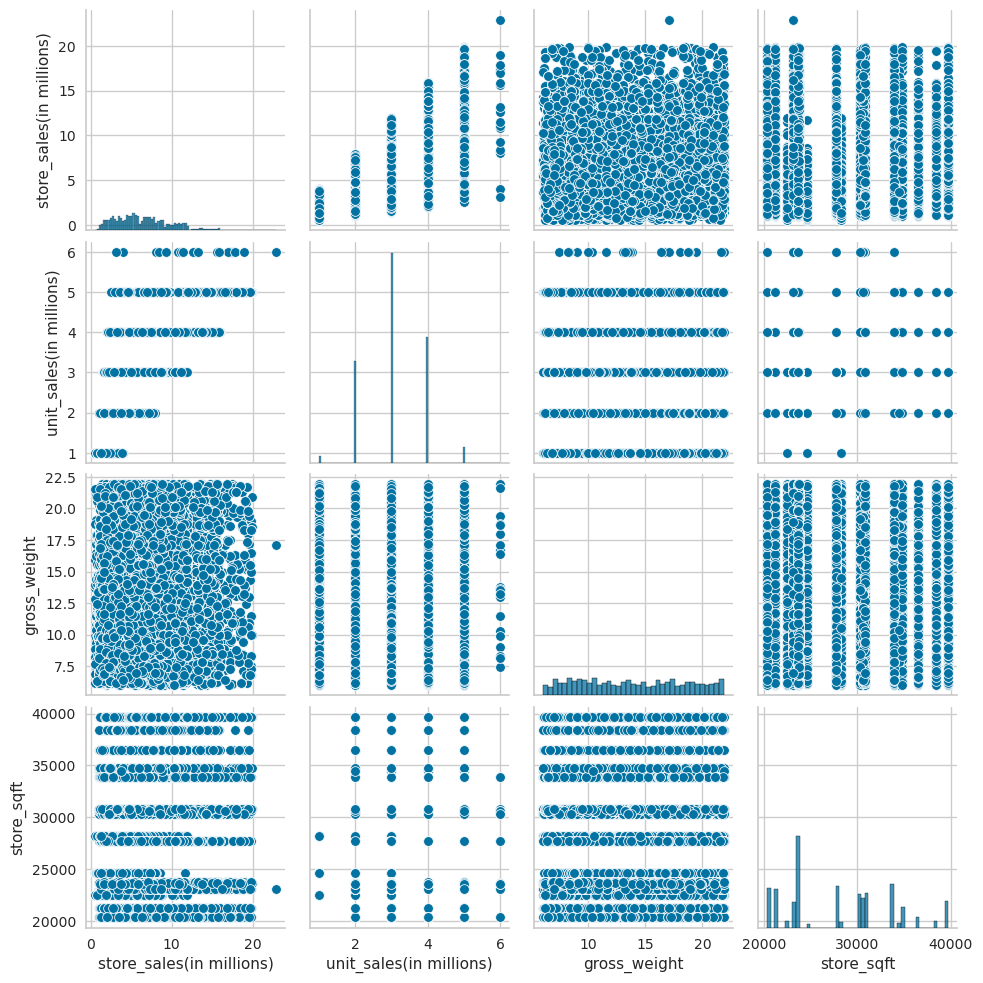

In [9]:
sns.pairplot(X[CONTINIOUS_FEATURES]);

**Observation:**
- Feature distribution seems to be different accross features
- Gross_weight is almost equaly distributed
- Unit_sales seams to have only of few different value

## Correlations

Next, we explore the correlation between the dataset's variables by visualizing a correlation matrix. This matrix provides valuable insights into the relationships and dependencies among the different features.

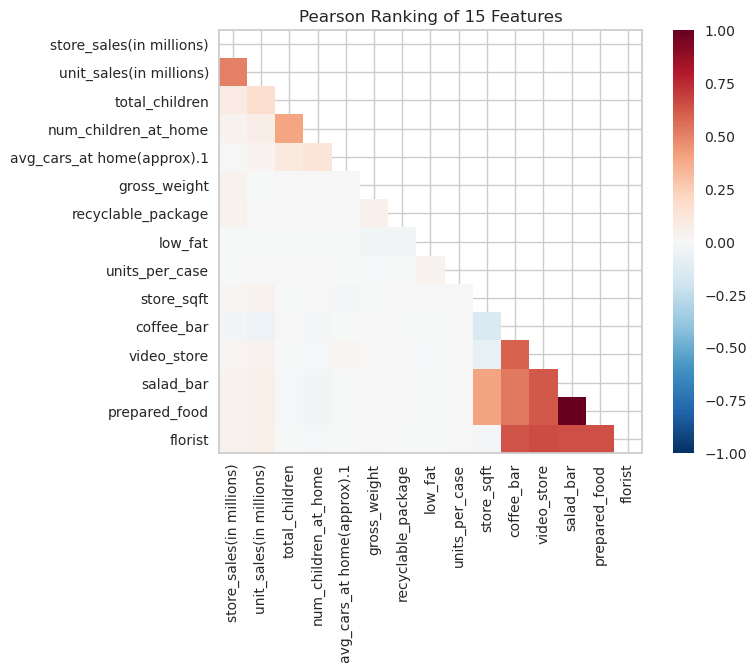

In [10]:
# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm="pearson")

visualizer.fit_transform(X, y)
visualizer.show();

**Observation:**
- Boolean feature for infrastructures are strongly releated
- Salad_bar and prepared_food are clearly correlated

## Baseline

To establish a baseline for our analysis, we begin by defining a baseline model using LinearRegression(). This baseline model will serve as a reference point against which we can evaluate the performance of more advanced or customized models.

We adopt a train-validation approach with an 80/20 split, where 80% of the data is used for training the model and 20% is reserved for validation purposes.

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

 mitigate the potential bias towards features with larger values, we employ `StandardScaler` to normalize the data and ensure equal importance across all features.

In [12]:
baseline_pipeline = make_pipeline(StandardScaler(), LinearRegression())

In [13]:
baseline_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

To reduce sensitivity to outliers, an alternative approach we can explore is to employ `RobustScaler` for preprocessing the data. 

In [14]:
robust_pipeline = make_pipeline(RobustScaler(), LinearRegression())

In [15]:
robust_pipeline.fit(X_train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('linearregression', LinearRegression())])

In [16]:
preds = baseline_pipeline.predict(X_valid)
robust_preds = robust_pipeline.predict(X_valid)

We are going to compare a few regression metrics:
- **R2**: The r2 coefficient is a statistical measure that represents the proportion of the variance in the dependent variable that can be explained by the independent variables in a regression model. *The advantage of the r2 coefficient is that we can interpret it has it ranges from 0 to 1. Higher is better.*

- **Mean Absolute error**: It measures the average of the absolute differences between the predicted and actual values. MAE doesn't take into account the direction of the error.

- **Mean Squared Log Error**: It measures the average of the logarithmic squared differences between the predicted and actual values. The. The advantage of *"values range from 0 up to millions and we don't want to punish deviations in prediction as much as with MSE"*.

Utilizing different evaluation metrics allows us to uncover various aspects and characteristics of the dataset by capturing different attributes of model performance.

In [17]:
print(
    f"""=== Baseline scores ===
R2 score with StandardScaler:{r2_score(y_valid, preds)}
Mean Absolute error with StandardScaler: {mean_absolute_error(y_valid, preds)}
Mean squared Log Error with StandardScaler: {mean_squared_log_error(y_valid, preds)}
"""
)

print(
    f"""=== RobustScaler scores ===
R2 score with RobustScaler:{r2_score(y_valid, robust_preds)}
Mean Absolute error with RobustScaler: {mean_absolute_error(y_valid, robust_preds)}
Mean squared Log Error with RobustScaler: {mean_squared_log_error(y_valid, robust_preds)}
"""
)

=== Baseline scores ===
R2 score with StandardScaler:0.016423702001124196
Mean Absolute error with StandardScaler: 25.750724498471286
Mean squared Log Error with StandardScaler: 0.10158585888427787

=== RobustScaler scores ===
R2 score with RobustScaler:0.01642370200112442
Mean Absolute error with RobustScaler: 25.750724498471286
Mean squared Log Error with RobustScaler: 0.10158585888427787



/home/h/micromamba/envs/ftml/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


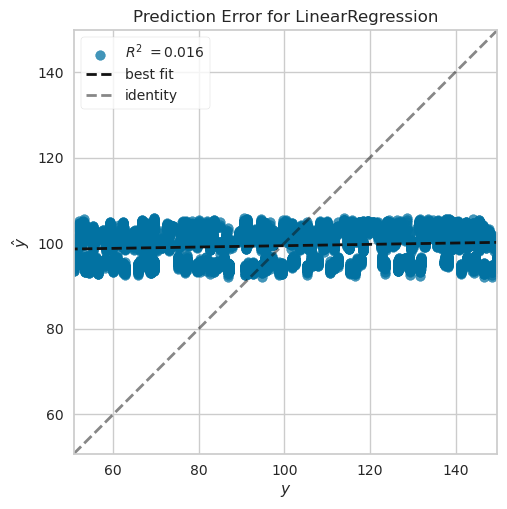

In [18]:
prediction_error(baseline_pipeline, X_train, y_train, X_valid, y_valid);

Upon analysis, we can note that the R2 score is a more stringent metric, imposing greater penalties on larger differences, while MAE and MSLE exhibit relatively milder penalties for larger differences. Furthermore, after evaluating the impact of RobustScaler, it appears that it does not enhance the results significantly. Therefore, we will continue to utilize StandardScaler as our preprocessing technique.

## Experimentations

We will proceed with experimenting different models for our analysis.

Initially, we utilize the sklearn graph to determine the suitable model type. Upon examining the vertices of the graph, we observe that Ridge is recommended as a potential choice. Therefore, we will proceed with trying out `Ridge` as one of our models.

In [19]:
ridge_pipeline = make_pipeline(StandardScaler(), Ridge())

In [20]:
ridge_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())])

In [21]:
preds = ridge_pipeline.predict(X_valid)

In [22]:
print(
    f"""=== Ridge scores ===
R2 score:{r2_score(y_valid, preds)}
Mean Absolute error: {mean_absolute_error(y_valid, preds)}
Mean squared Log Error: {mean_squared_log_error(y_valid, preds)}
"""
)

=== Ridge scores ===
R2 score:0.016423690556348403
Mean Absolute error: 25.75072533051272
Mean squared Log Error: 0.10158586151495762



/home/h/micromamba/envs/ftml/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


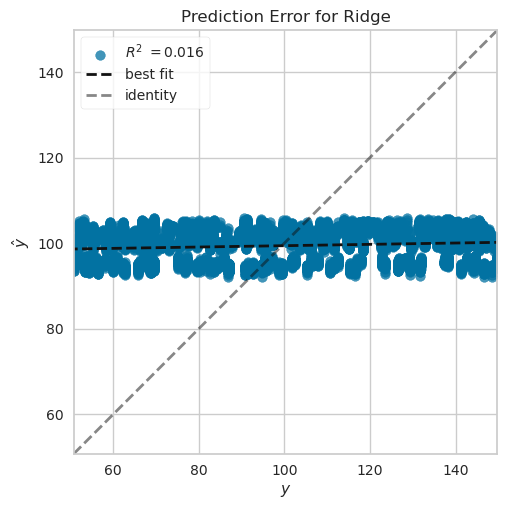

In [23]:
prediction_error(ridge_pipeline, X_train, y_train, X_valid, y_valid);

After assessing the results, it appears that Ridge does not significantly improve the scores. Thus, without any optimization, we will continue exploring other models before attempting to optimize a specific one. As per recommendations from several papers, we will commence by testing `RandomForestRegressor` as it shows promise as a potential model choice.

In [24]:
rdf_pipeline = make_pipeline(StandardScaler(), RandomForestRegressor())

In [25]:
rdf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [26]:
preds = rdf_pipeline.predict(X_valid)

In [27]:
print(
    f"""=== RandomForestRegressor scores ===
R2 score:{r2_score(y_valid, preds)}
Mean Absolute error: {mean_absolute_error(y_valid, preds)}
Mean squared Log Error: {mean_squared_log_error(y_valid, preds)}
"""
)

=== RandomForestRegressor scores ===
R2 score:0.014218325381841201
Mean Absolute error: 25.427805099011277
Mean squared Log Error: 0.10103672447445765



/home/h/micromamba/envs/ftml/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


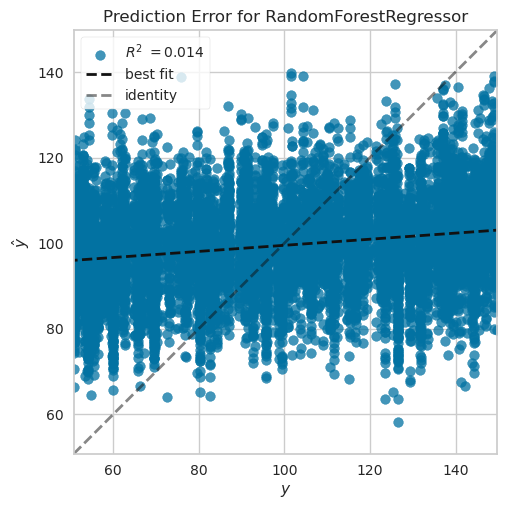

In [28]:
prediction_error(rdf_pipeline, X_train, y_train, X_valid, y_valid);

Upon comparison, the results obtained with Ridge, RandomForestRegressor and LinearRegression are nearly identical. As a final step, we can explore the regressor methods such as XGBoost, CatBoost, or LightGBM, which are known to excel in tabular data scenarios. Considering this, we will proceed with LightGBM as our chosen regressor method.

In [29]:
lgbm_reg = LGBMRegressor()

In [30]:
lgbm_pipeline = make_pipeline(StandardScaler(), lgbm_reg)

In [31]:
lgbm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmregressor', LGBMRegressor())])

In [32]:
preds = lgbm_pipeline.predict(X_valid)

In [33]:
print(
    f"""=== LGBM scores ===
R2 score:{r2_score(y_valid, preds)}
Mean Absolute error: {mean_absolute_error(y_valid, preds)}
Mean squared Log Error: {mean_squared_log_error(y_valid, preds)}
"""
)

=== LGBM scores ===
R2 score:0.06630832932764885
Mean Absolute error: 25.072766174890997
Mean squared Log Error: 0.09643268212937438



/home/h/micromamba/envs/ftml/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


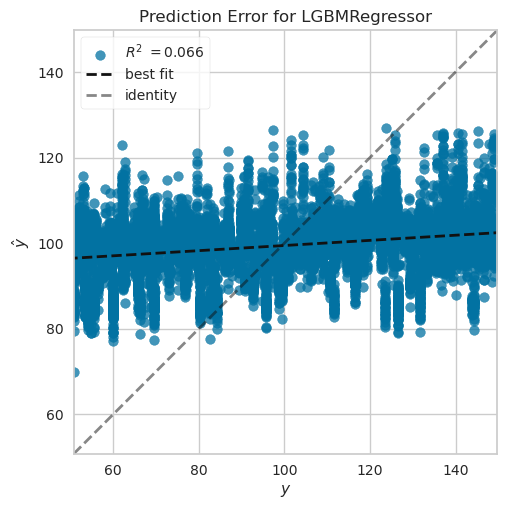

In [34]:
prediction_error(lgbm_pipeline, X_train, y_train, X_valid, y_valid);

Remarkably, LightGBM improves the results even without any optimization. We can explore the feature importance determined by LightGBM, which will provide valuable insights into the relative significance of different features within our model.

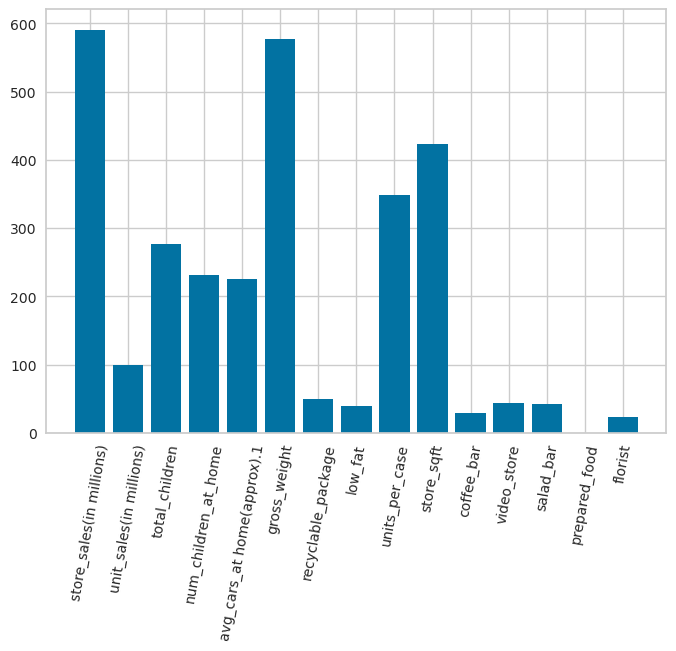

In [35]:
plt.bar(list(X_valid.columns), lgbm_reg.feature_importances_)
plt.xticks(rotation=80);

**Observations**:
- Several features, such as prepared_food, low_fat, and florist, appear to have relatively lower importance in the model.
- On the other hand, store_sales and gross_weight emerge as highly informative features.

Considering these findings, it may be worth considering a dimensionality reduction technique like Principal Component Analysis (PCA) to reduce the data's dimensionality while retaining important information. 

In [36]:
for nb_compnents in range(14, 8, -1):
    pca = PCA(n_components=nb_compnents)
    X_train_transformed = pca.fit_transform(X_train)
    X_valid_transformed = pca.fit_transform(X_valid)
    lgbm_pipeline.fit(X_train_transformed, y_train)
    preds = lgbm_pipeline.predict(X_valid_transformed)
    print(
        f"Nb_components:{nb_compnents}, R2 score:{r2_score(y_valid, preds)}, MAE: {mean_absolute_error(y_valid, preds)} MSLE: {mean_squared_log_error(y_valid, preds)}"
    )

Nb_components:14, R2 score:0.05366962718382984, MAE: 25.139904493334257 MSLE: 0.09802403605949912
Nb_components:13, R2 score:0.055282449640236986, MAE: 25.105250783468843 MSLE: 0.09796895596491417
Nb_components:12, R2 score:0.05145050909763249, MAE: 25.15114393076602 MSLE: 0.09857253334291388
Nb_components:11, R2 score:0.04846415770868928, MAE: 25.204180501461707 MSLE: 0.0989551514517764
Nb_components:10, R2 score:0.047608666324784776, MAE: 25.192628373791436 MSLE: 0.09903428726503882
Nb_components:9, R2 score:0.04987738349273807, MAE: 25.249337680200867 MSLE: 0.0987926827701501


Upon evaluation, it appears that PCA does not have a noticeable impact on the MAE and MSLE metrics. However, it is evident that reducing the number of components from 15 to 14 in PCA leads to a decrease in the R2 coefficient. We could consider dropping less significant features from the model in an attempt to streamline and optimize its performance.

In [37]:
columns_to_drop = [
    "recyclable_package",
    "low_fat",
    "coffee_bar",
    "video_store",
    "salad_bar",
    "prepared_food",
    "florist",
]
X_train_important_features = X_train.drop(columns=columns_to_drop)
X_valid_important_features = X_valid.drop(columns=columns_to_drop)

In [38]:
lgbm_pipeline.fit(X_train_important_features, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmregressor', LGBMRegressor())])

In [39]:
preds = lgbm_pipeline.predict(X_valid_important_features)

In [40]:
print(
    f"""=== LGBM scores ===
R2 score:{r2_score(y_valid, preds)}
Mean Absolute error: {mean_absolute_error(y_valid, preds)}
Mean squared Log Error: {mean_squared_log_error(y_valid, preds)}
"""
)

=== LGBM scores ===
R2 score:0.06522741608082194
Mean Absolute error: 25.08637551058841
Mean squared Log Error: 0.0965079384566674



/home/h/micromamba/envs/ftml/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


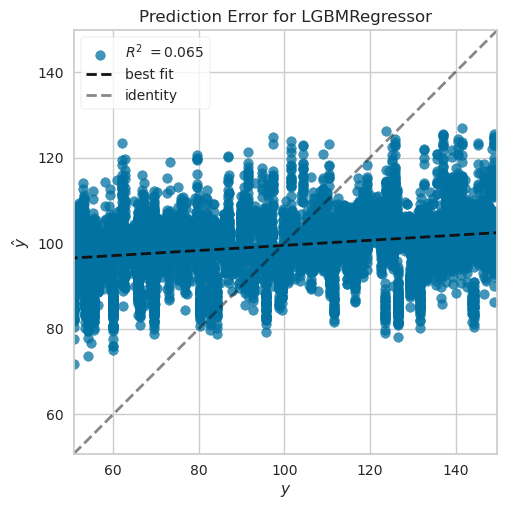

In [41]:
prediction_error(
    lgbm_pipeline,
    X_train_important_features,
    y_train,
    X_valid_important_features,
    y_valid,
);

**Observations:**
- Notably, dropping 7 less important features has minimal impact on the overall results.

## Optimization

Now, to enhance the regression results, we can leverage Optuna and cross-validation techniques. By utilizing Optuna, we can systematically tune the hyperparameters of the model, seeking optimal combinations that yield improved performance. Using cross-validation validates that we're not overfitting on a part of the dataset. 

In [57]:
def objective(trial):
    params = {
        "objective": "regression",
        "reg_alpha": trial.suggest_float(
            "reg_alpha", 0.001, 10
        ),  #  L1 regularization term on weights.
        "reg_lambda": trial.suggest_float(
            "reg_lambda",
            0.001,
            10,
        ),  # L2 regularization term on weights.
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "random_state": 42,
        "n_jobs": -1,
    }
    scaler = StandardScaler()
    reg = LGBMRegressor(**params)
    return np.mean(cross_val_score(reg, scaler.fit_transform(X_train_important_features), y_train, scoring=make_scorer(r2_score)))

In [59]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2023-06-21 17:01:26,834] A new study created in memory with name: no-name-83d539d0-594e-43be-a8b6-127c9689b54b
[I 2023-06-21 17:01:29,561] Trial 0 finished with value: 0.023944879533054308 and parameters: {'reg_alpha': 8.508493298415637, 'reg_lambda': 9.608571281862362, 'num_leaves': 224, 'max_depth': 18}. Best is trial 0 with value: 0.023944879533054308.
[I 2023-06-21 17:01:30,870] Trial 1 finished with value: 0.0406889742533467 and parameters: {'reg_alpha': 1.5785158124493952, 'reg_lambda': 1.8090871560234274, 'num_leaves': 121, 'max_depth': 8}. Best is trial 1 with value: 0.0406889742533467.
[I 2023-06-21 17:01:35,209] Trial 2 finished with value: 0.02331177185218678 and parameters: {'reg_alpha': 4.280075203185156, 'reg_lambda': 7.38767056313028, 'num_leaves': 233, 'max_depth': 17}. Best is trial 1 with value: 0.0406889742533467.
[I 2023-06-21 17:01:37,192] Trial 3 finished with value: 0.03520722536759326 and parameters: {'reg_alpha': 6.346662568485056, 'reg_lambda': 8.7627725655

In [50]:
best_reg = LGBMRegressor(**study.best_params)

In [60]:
scaler = StandardScaler()

In [61]:
best_reg.fit(scaler.fit_transform(X_train_important_features), y_train)

LGBMRegressor(max_depth=15, num_leaves=14, reg_alpha=4.777820820297822,
              reg_lambda=0.3136361087614108)

In [62]:
preds = best_reg.predict(scaler.fit_transform(X_valid_important_features))

In [63]:
print(
    f"""=== LGBM best params scores ===
R2 score:{r2_score(y_valid, preds)}
Mean Absolute error: {mean_absolute_error(y_valid, preds)}
Mean squared Log Error: {mean_squared_log_error(y_valid, preds)}
"""
)

=== LGBM best params scores ===
R2 score:0.06087386231133218
Mean Absolute error: 25.154270702074303
Mean squared Log Error: 0.09665372677347142



In [64]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

**Observations:**

- The hyperparameter num_leavers appears to have the most impact on the model.
- When comparing the regression parameters, l1 regularization has the most impact on the model (but their impact isn't really important)

In [65]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

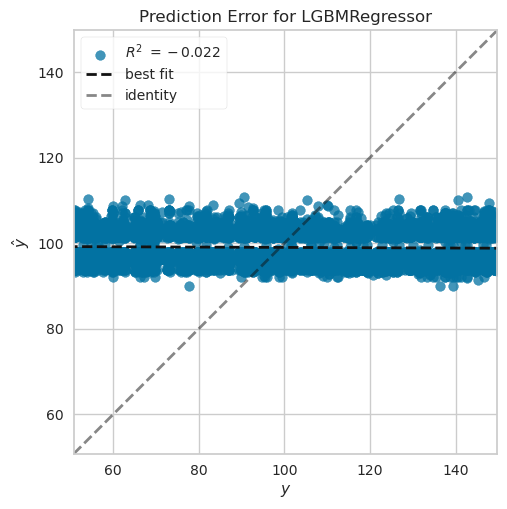

In [66]:
prediction_error(
    best_reg,
    X_train_important_features,
    y_train,
    X_valid_important_features,
    y_valid,
);

#### Hyperparameters

We opted to optimize four specific hyperparameters in our model:
- **Max_depth**
- **Number of leaves**
- **Regularization alpha**:  L1 regularization term on weights.
- **Regularization lambda**: L2 regularization term on weights.

Hyperparameter optimization of max_dept, number_of_leaves, regularization_l1 an regularization_l2 doesn't improve the model. But we still obtain really good result with the base parameters and only 8 features instead of the 15.

## Conclusion

Throughout this notebook, we have explored various models and expanded upon the knowledge acquired in class by experimenting with additional models such as LightGBM and RandomForest Regressor. This approach allowed us to broaden our understanding and explore different algorithms to find the most suitable one for our regression task. In our analysis, we compared a baseline model using LinearRegression with Ridge, RandomForestRegressor, and LGBMRegressor. Additionally, we explored dimensionality reduction using PCA and examined feature importance. Finally, we proceeded to optimize a tree-based algorithm to enhance our overall results, but it didn't achieve the expected result. Working with this dataset was particularly intriguing and rewarding, as it provided us with the opportunity to analyze real data from Food Mart. 